In [26]:
import reciprocalspaceship as rs
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits    import mplot3d
import gemmi
from dw_tools import modify_ds, wilson, plots, fitting_dw, map_prep_tools

In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [3]:
%load_ext autoreload
%autoreload 2

## Description
In this notebook, we determine
- the difference in mean value between LQ92 ON and OFF data as a function of resolution and OFF amplitude
- the double-wilson correlation parameters $a$ and $b$ between ON and OFF data

**Preparatory Steps**
1. The ON and OFF data were scaled together in abismal.
2. The ON, OFF, SSRL, and 4EUL structure factors were normalized in DW notebook 1: **1_Dataset_prep_and_local_scaling.ipynb**
3. rDW parameters were determined in **3_Fitting_DW_to_paired_data** (LCLS/off v 4EUL or SSRL; SSRL was better after phenix filter) or in this notebook (ON v OFF, below)


In [4]:
path = "C:\\Users\\Doeke Hekstra\\Documents\\Lab_Hekstra\\Lab_projects\\Hekstra Doeke THz\\LQ92_EGFP_300fs\\"
fname_off = "off_scaled_sigp4.mtz"
fname_on  = "on_scaled_sigp4.mtz"

### Mapping the ASUs
Since the ON and OFF data were merged into P21 1 1 and P21 21 21 respectively, we need to figure out how to expand the OFF data to match the ON data. Ideally, we can take that information from scaling. Here, we look at reciprocal space coverage for both datasets.

In [5]:
ds_off=rs.read_mtz(path+fname_off)
modify_ds.ds_add_rs(ds_off)

# plt.ion; fig = plt.figure(figsize=(6,6))
# ax = plt.axes(projection="3d")
# ax.scatter3D(ds_off["rs_a"], ds_off["rs_b"], ds_off["rs_c"],alpha=0.01)
# ax.view_init(elev=0., azim=1200.)
# ax.set_xlabel("rs_a"); ax.set_ylabel("rs_b"); ax.set_zlabel("rs_c")
# plt.draw()

In [6]:
ds_on=rs.read_mtz(path+fname_on)
ds_on["SIGF"]=ds_on["SigF"]
modify_ds.ds_add_rs(ds_on)
ds_on.info()

# I used the following to figure out ASU mapping
# plt.ion; fig = plt.figure(figsize=(6,6))
# ax = plt.axes(projection="3d")
# ax.scatter3D(ds_on["rs_a"], ds_on["rs_b"], ds_on["rs_c"],alpha=0.01)
# ax.view_init(elev=0., azim=1200.)
# ax.set_xlabel("rs_a"); ax.set_ylabel("rs_b"); ax.set_zlabel("rs_c")
# plt.draw()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 42885 entries, (0, 0, 4) to (29, 9, 6)
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype                
---  ------           --------------  -----                
 0   F                42885 non-null  SFAmplitude          
 1   SigF             42885 non-null  Stddev               
 2   I                42885 non-null  Intensity            
 3   SigI             42885 non-null  Stddev               
 4   FP               42885 non-null  SFAmplitude          
 5   SIGFP            42885 non-null  Stddev               
 6   rs_a             42885 non-null  MTZReal              
 7   rs_b             42885 non-null  MTZReal              
 8   rs_c             42885 non-null  MTZReal              
 9   dHKL             42885 non-null  MTZReal              
 10  CENTRIC          42885 non-null  bool                 
 11  EPSILON          42885 non-null  MTZInt               
 12  EP_1_aniso_1     42885 no

In [7]:
# ds_off.info()

#### Merging after mapping ASUs

In [8]:
ds_off = rs.read_mtz(path+fname_off) # re-reads this
ds_off_expanded = ds_off.append(ds_off.apply_symop('x,y,-z')) # based on the above plots (rotation * Friedel)
ds_off_expanded.spacegroup = ds_on.spacegroup 
ds_off_expanded["SIGF"]=ds_off_expanded["SigF"]
ds_off_expanded["SIGF"]=ds_off_expanded["SigF"]
ds_off_expanded.info()


ds1_2 = ds_off_expanded.merge(ds_on, left_index=True, right_index=True, suffixes=("_off", "_on"))
ds1_2.compute_dHKL(inplace=True)
ds1_2.label_centrics(inplace=True)
ds1_2.compute_multiplicity(inplace=True)
ds1_2, bin_labels = ds1_2.assign_resolution_bins(bins=20, inplace=True, return_labels=True);

print("Correlation coefficients:\n")
print(np.corrcoef(ds1_2["F_off"],ds1_2["F_on"]))

# print(ds1_2["F_on"].head()) # sanity check
# print(ds_off_expanded["F"].head())

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 42274 entries, (0, 0, 4) to (29, 9, -6)
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype                
---  ------           --------------  -----                
 0   F                42274 non-null  SFAmplitude          
 1   SigF             42274 non-null  Stddev               
 2   I                42274 non-null  Intensity            
 3   SigI             42274 non-null  Stddev               
 4   FP               42274 non-null  SFAmplitude          
 5   SIGFP            42274 non-null  Stddev               
 6   rs_a             42274 non-null  MTZReal              
 7   rs_b             42274 non-null  MTZReal              
 8   rs_c             42274 non-null  MTZReal              
 9   dHKL             42274 non-null  MTZReal              
 10  CENTRIC          42274 non-null  bool                 
 11  EPSILON          42274 non-null  MTZInt               
 12  EP_1_aniso_1     42274 n

In [9]:
# ds1_2.info()

### Examination of errors SIGFP

In [10]:
# ds1_2.info()
EP1_label = "EP_1_aniso_1_off"
EP2_label = "EP_1_aniso_1_on"
dHKL_label = "dHKL"
dHKL_bin_label = "bin"

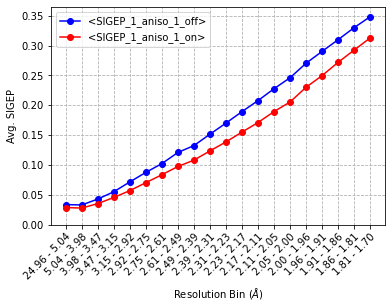

In [11]:
result = ds1_2.groupby(dHKL_bin_label)["SIG" + EP1_label].mean()
plt.plot(result,'bo-', label="<SIG" + EP1_label + ">")
result = ds1_2.groupby(dHKL_bin_label)["SIG" + EP2_label].mean()
plt.plot(result,'ro-', label="<SIG" + EP2_label + ">")
plt.xticks(result.index, bin_labels, rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel(r"Resolution Bin ($\AA$)")
plt.ylabel("Avg. SIGEP")
plt.grid(linestyle='--')
plt.ylim([0,plt.ylim()[1]]); plt.legend(); plt.show()

### Determination of Double-Wilson parameters
This has only been established for normalized structure factors, so I should probably redo this.

In [12]:
(a,b) = fitting_dw.fit_ab(ds1_2,labels=[EP1_label,EP2_label],\
                          dHKL_label=dHKL_label, dHKL_bin_label=dHKL_bin_label)
print(a)
print(f"a: {a:.4}")
print(f"b: {b:.4}")

`xtol` termination condition is satisfied.
Function evaluations 13, initial cost 4.6028e+00, final cost 5.2016e-02, first-order optimality 2.13e-06.
0.988854759026095
a: 0.9889
b: 6.23e-15


In [13]:
fitting_dw.eff_r_dw_per_hkl(ds1_2,a,b,label=EP1_label, dHKL_label=dHKL_label, inplace=True);
fitting_dw.eff_r_dw_per_hkl(ds1_2,a,b,label=EP2_label, dHKL_label=dHKL_label, inplace=True);

In [14]:
ds1_2.to_pickle(path + "LQ92_OFF_expanded_ON_P21_w_rDW_aniso1.pkl")

In [15]:
import pandas as pd
test = pd.read_pickle(path + "LQ92_OFF_expanded_ON_P21_w_rDW_aniso1.pkl")
# test.info()

### Learning the map from $d_{HKL}$ and $|E_{off}|$ to skew
See https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor

In [16]:
tmp = ds1_2.reset_index()
# tmp.info()
X = tmp[["dHKL","F_off"]].to_numpy()
y = (ds1_2[["F_on"]].to_numpy()/ds1_2[["F_off"]].to_numpy())-1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
regr = MLPRegressor(random_state=1, max_iter=500,activation='relu',solver='adam').fit(X_train, y_train) # MSE is default loss function
regr.score(X_test, y_test)

C:\Users\Doeke Hekstra\.conda\envs\crystallography\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.039134586277431826

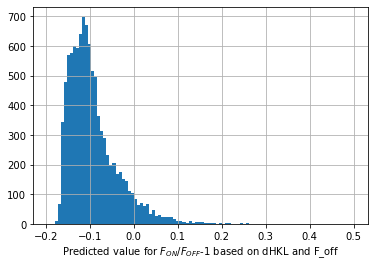

-0.1095265


In [17]:
tmp=regr.predict(X_test)
plt.hist(tmp,100)
plt.grid()
plt.xlabel(r"Predicted value for $F_{ON}/F_{OFF}$-1 based on dHKL and F_off")
print
plt.show()

print(np.mean(y))

### Obtaining phase errors
Output from "Model-based phases" in PHENIX on the cluster.

In [18]:
ds_ssrl=rs.read_mtz(path+"EGFP_phases_w_FOM_SSRL.mtz") # already in P21
# ds_ssrl.info()
ds_ssrl.spacegroup=ds1_2.spacegroup
ds1_2_w_varphi = ds1_2.merge(ds_ssrl[["FOM","PHIFMODEL", "FMODEL"]], left_index=True, right_index=True, suffixes=("", "SSRL"))

print(len(ds1_2.index))
print(len(ds_ssrl.index))
print(len(ds1_2_w_varphi.index))
ds1_2_w_varphi["var_phi_SSRL"]=np.arccos(ds1_2_w_varphi["FOM"])**2

40172
93887
39707


### Calculating differences
... and a simple clip on extremes

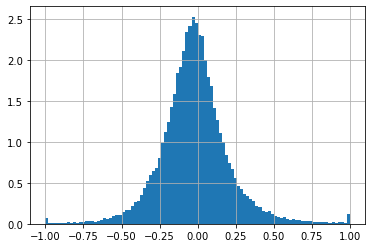

4.429722
-1.8606782
1.4289524343013935
-1.2433219822645185


In [19]:
ds1_2_w_varphi["DE"]=ds1_2_w_varphi["EP_1_knn_on"]-ds1_2_w_varphi["EP_1_knn_off"]
ds1_2_w_varphi["SIGDE"]=np.sqrt(ds1_2_w_varphi["SIGEP_1_knn_on"]**2+ds1_2_w_varphi["SIGEP_1_knn_off"]**2)
ds1_2_w_varphi["DE_th"]=ds1_2_w_varphi["DE"].clip(-1,1)

plt.hist(ds1_2_w_varphi["DE_th"],density=True,bins=100)
plt.grid()
plt.show()
print(np.amax(ds1_2_w_varphi["DE"]))
print(np.amin(ds1_2_w_varphi["DE"]))
print(np.percentile(ds1_2_w_varphi["DE"],99.95))
print(np.percentile(ds1_2_w_varphi["DE"],0.05))

### Calculating difference weights
From **7_Revisiting_difference_maps**, we have:

\begin{align}
w_h & = \frac{\Delta_h^2}{\Delta_h^2 + k_h^2 \sigma^2_{h,on} +\sigma^2_{h,off}+\Delta_h^2 \sigma^2_{\varphi_{h,OFF}} + \frac{1}{2}p^2 (1-r_{DW}^2)} \\
& = \frac{\Delta_h^2}{
          \Delta_h^2 \left( 1 + \sigma^2_{\varphi_{h,OFF}}        \right) + 
                     \left(k_h^2 \sigma^2_{h,on} +\sigma^2_{h,off}\right) + 
                     \frac{1}{2}p^2 (1-r_{DW}^2)
                     } \\
& \approx \frac{\Delta_h^2}{
          \Delta_h^2 \left( 1 + \sigma^2_{\varphi_{h,OFF}}        \right) + 
                     \left(k_h^2 \sigma^2_{h,on} +\sigma^2_{h,off}\right) + 
                     p\theta 
                     } < 1\\
\end{align}

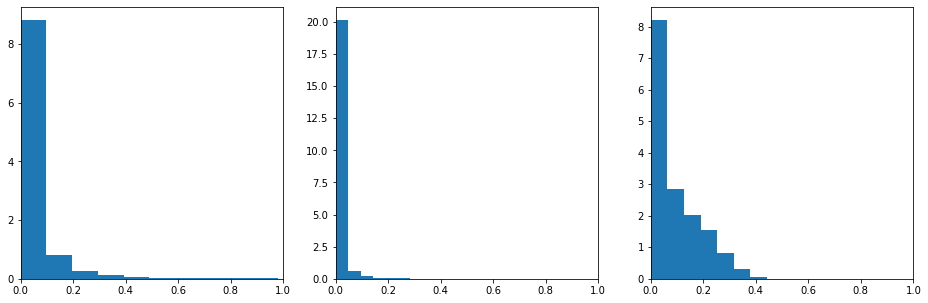

0.00092


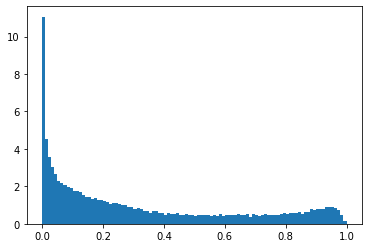

In [20]:
# ds1_2_w_varphi.info()
p = 0.2
theta = p*0.023
w = ds1_2_w_varphi["DE"]**2/(ds1_2_w_varphi["DE"]**2*(1+ds1_2_w_varphi["var_phi_SSRL"]) + ds1_2_w_varphi["SIGDE"]**2 + p*theta)
w1 = ds1_2_w_varphi["DE"]**2
w2 = ds1_2_w_varphi["DE"]**2 * ds1_2_w_varphi["var_phi_SSRL"]
w3 = ds1_2_w_varphi["SIGDE"]**2 
w4 = p*theta

fig, _axs = plt.subplots(nrows=1, ncols=3,figsize=(16,5))
axs = _axs.flatten()

axs[0].hist(w1,bins=200,density=True)
axs[0].set_xlim([0,1])
axs[1].hist(w2,bins=20,density=True)
axs[1].set_xlim([0,1])
axs[2].hist(w3,bins=10,density=True)
axs[2].set_xlim([0,1])
plt.show()
print(w4)

plt.hist(w,bins=100,density=True)
plt.show()

In [21]:
ds_diff = rs.read_mtz(path+"difference.mtz")
ds_diff.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 47451 entries, (0, 0, 4) to (29, 8, -8)
Data columns (total 28 columns):
 #   Column     Non-Null Count  Dtype      
---  ------     --------------  -----      
 0   Foff       47451 non-null  SFAmplitude
 1   SigFoff    47451 non-null  Stddev     
 2   Fon        47451 non-null  SFAmplitude
 3   SigFon     47451 non-null  Stddev     
 4   PhiFoff    47451 non-null  Phase      
 5   F-model    47451 non-null  SFAmplitude
 6   DeltaF     47451 non-null  SFAmplitude
 7   SigDeltaF  47451 non-null  Stddev     
 8   W          47451 non-null  Weight     
 9   DH         47451 non-null  Weight     
 10  ML         47451 non-null  Weight     
 11  S10        47451 non-null  Weight     
 12  S20        47451 non-null  Weight     
 13  S30        47451 non-null  Weight     
 14  S40        47451 non-null  Weight     
 15  S50        47451 non-null  Weight     
 16  S60        47451 non-null  Weight     
 17  S70        47451 non-null  W

In [22]:
# for n in range(5):
#     ds1_2_final["Fesf4_random_"+str(n)] = ds1_2_final["E_MODEL"] + 4*ds1_2_final["WT"]*ds1_2_final["DE_th"]*\
#     np.sign(np.random.random(size=ds1_2_final["DE_th"].to_numpy().shape)-0.5)
#     ds1_2_final["Fesf4_random_"+str(n)] = ds1_2_final["Fesf4_random_"+str(n)].astype("SFAmplitude")


In [23]:
ds1_2_w_varphi["WT"]=w
ds1_2_w_varphi["WT2"]=w*np.exp(30/ds1_2_w_varphi["dHKL"]**2)

ds_out = ds1_2_w_varphi[["EP_1_aniso_1_off","DE_th", "PHIFMODEL", "WT", "WT2"]].copy()
ds_out["WT"]=ds_out["WT"].astype('Weight')
ds_out["WT2"]=ds_out["WT2"].astype('Weight')
ds_out["EP_1_aniso_1_off"]=ds_out["EP_1_aniso_1_off"].astype("SFAmplitude")
ds_out["DE_th"]=ds_out["DE_th"].astype("SFAmplitude")
ds_out.info()
ds_out.write_mtz(path+"test_wt_diff_map_sigp4.mtz")

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 39707 entries, (0, 0, 4) to (29, 9, 6)
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype      
---  ------            --------------  -----      
 0   EP_1_aniso_1_off  39707 non-null  SFAmplitude
 1   DE_th             39707 non-null  SFAmplitude
 2   PHIFMODEL         39707 non-null  Phase      
 3   WT                39707 non-null  Weight     
 4   WT2               39707 non-null  Weight     
dtypes: Phase(1), SFAmplitude(2), Weight(2)
memory usage: 1.6 MB


## Calculating extrapolated structure factors
We will use 
1. $F_{model}$ as the basis; 
2. weights, allowing us to go to high completeness for clear maps while suppressing noisy contributions; 
3. normalized $\Delta E$ from **1_Dataset_prep_and_local_scaling** to maximally remove contributions from OFF. 

**NOTE**: for ESFs, it is less important to do this right and we could consider doing this with skewed $\Delta F$.  

**TO DO:**: (1) Apply B; (2) Output errors

In [24]:
ds_norm_model = rs.read_mtz(path+"SSRL_FMODEL_norm_use_aniso_1_only.mtz")
ds_norm_model["E_MODEL"] = ds_norm_model["EP_1_aniso_1"]
ds1_2_final = ds1_2_w_varphi.merge(ds_norm_model[["E_MODEL"]], left_index=True, right_index=True, suffixes=("", "SSRL"))
ds1_2_final.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 39707 entries, (0, 0, 4) to (29, 9, 6)
Data columns (total 55 columns):
 #   Column                     Non-Null Count  Dtype                
---  ------                     --------------  -----                
 0   F_off                      39707 non-null  SFAmplitude          
 1   SigF_off                   39707 non-null  Stddev               
 2   I_off                      39707 non-null  Intensity            
 3   SigI_off                   39707 non-null  Stddev               
 4   FP_off                     39707 non-null  SFAmplitude          
 5   SIGFP_off                  39707 non-null  Stddev               
 6   rs_a_off                   39707 non-null  MTZReal              
 7   rs_b_off                   39707 non-null  MTZReal              
 8   rs_c_off                   39707 non-null  MTZReal              
 9   dHKL_off                   39707 non-null  MTZReal              
 10  CENTRIC_off              

YES
<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 39707 entries, (0, 0, 4) to (29, 9, 6)
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype      
---  ------          --------------  -----      
 0   FMODEL          39707 non-null  SFAmplitude
 1   Fesf1           39707 non-null  SFAmplitude
 2   Fesf2           39707 non-null  SFAmplitude
 3   Fesf4           39707 non-null  SFAmplitude
 4   Fesf8           39707 non-null  SFAmplitude
 5   Fesf16          39707 non-null  SFAmplitude
 6   Fesf32          39707 non-null  SFAmplitude
 7   Fesf4_random_0  39707 non-null  SFAmplitude
 8   Fesf4_random_1  39707 non-null  SFAmplitude
 9   Fesf4_random_2  39707 non-null  SFAmplitude
 10  Fesf4_random_3  39707 non-null  SFAmplitude
 11  Fesf4_random_4  39707 non-null  SFAmplitude
 12  PHIFMODEL       39707 non-null  Phase      
 13  dHKL            39707 non-null  MTZReal    
 14  Fesf4_B_20      39707 non-null  SFAmplitude
dtypes: MTZReal(1), Phase(1), SFA

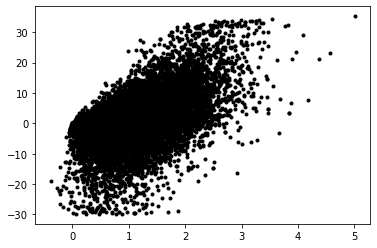

In [29]:
for n in [1,2,4,8,16,32]:
    ds1_2_final["Fesf"+str(n)] = ds1_2_final["E_MODEL"] + n*ds1_2_final["WT"]*ds1_2_final["DE_th"]
    ds1_2_final["Fesf"+str(n)] = ds1_2_final["Fesf"+str(n)].astype("SFAmplitude")

for n in range(5):
    ds1_2_final["Fesf4_random_"+str(n)] = ds1_2_final["E_MODEL"] + 4*ds1_2_final["WT"]*ds1_2_final["DE_th"]*\
    np.sign(np.random.random(size=ds1_2_final["DE_th"].to_numpy().shape)-0.5)
    ds1_2_final["Fesf4_random_"+str(n)] = ds1_2_final["Fesf4_random_"+str(n)].astype("SFAmplitude")
# ds1_2_w_varphi.info()

ds_out = ds1_2_final[["FMODEL","Fesf1","Fesf2","Fesf4","Fesf8","Fesf16","Fesf32","Fesf4_random_0","Fesf4_random_1","Fesf4_random_2",\
                      "Fesf4_random_3","Fesf4_random_4", "PHIFMODEL", "dHKL"]].copy()

# from dw_tools import map_prep_tools
map_prep_tools.apply_iso_B(ds_out, "Fesf4",B=20)
map_prep_tools.apply_iso_B(ds_out, "Fesf8",B=20)
map_prep_tools.apply_iso_B(ds_out, "Fesf16",B=20)
ds_out.info()
ds_out.write_mtz(path+"test_Fesf_sigp4.mtz")

plt.plot(ds1_2_final["Fesf1"],ds1_2_final["Fesf32"],'k.')
plt.show()